---
title: "Supervised Learning"
author: "Nandini Kodali"
format:
    html: 
        code-fold: true
---

{{< include SupervisedLearning.qmd >}}

# Required Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures



# Feature Selection
**Feature Selection** is the process of identifying the most relevant features from a dataset that contribute significantly to predicting the target variable. By reducing the number of features, it improves computational efficiency during training, minimizes the risk of overfitting, and enhances model performance. Additionally, reducing feature complexity simplifies models, making them easier to interpret and explain, which is crucial for understanding the underlying data relationships.

In [6]:
# Define the binary target variable
df = pd.read_csv("../../data/processed-data/pitstop_with_positions.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df['points_category'] = df['position'].apply(lambda x: 1 if x <= 10 else 0)


In [7]:
df.head()

,Year,Round,RaceName,DriverID,Lap1,Lap2,Lap3,Lap4,Lap5,Lap6,...,Duration2,Duration3,Duration4,Duration5,Duration6,Duration7,constructorName,position,grid,points_category
0,2011,1,Australian Grand Prix,alguersuari,-1.492522,-0.208201,1.339923,-0.281099,-0.15023,-0.074145,...,0.733521,1.882538,-0.277274,-0.130754,-0.060017,-0.01976,AlphaTauri,11.0,12.0,0
1,2011,1,Australian Grand Prix,alonso,-0.414215,0.355923,1.723412,-0.281099,-0.15023,-0.074145,...,0.755727,1.679973,-0.277274,-0.130754,-0.060017,-0.01976,Ferrari,4.0,5.0,1
2,2011,1,Australian Grand Prix,ambrosio,-0.218159,0.976458,-0.577525,-0.281099,-0.15023,-0.074145,...,0.896614,-0.580401,-0.277274,-0.130754,-0.060017,-0.01976,Marussia,14.0,22.0,0
3,2011,1,Australian Grand Prix,barrichello,-0.316187,0.130273,0.956433,3.039918,-0.15023,-0.074145,...,1.835036,0.998617,3.860649,-0.130754,-0.060017,-0.01976,Williams,16.0,17.0,0
4,2011,1,Australian Grand Prix,buemi,-0.120131,0.468747,-0.577525,-0.281099,-0.15023,-0.074145,...,0.621420,-0.580401,-0.277274,-0.130754,-0.060017,-0.01976,AlphaTauri,8.0,10.0,1


In [8]:
# Define features and target
features = [
    "Year",
    "Lap1", "Lap2", "Lap3", "Lap4", "Lap5",
    "Stop1", "Stop2", "Stop3", "Stop4", "Stop5", 
    "Duration1", "Duration2", "Duration3", "Duration4", "Duration5",
    "Duration6", "Duration7", "grid"
]
X = df[features]
y = df["points_category"]  


## Correlation Analysis
Correlation analysis helps identify features that are strongly correlated with the target variable.

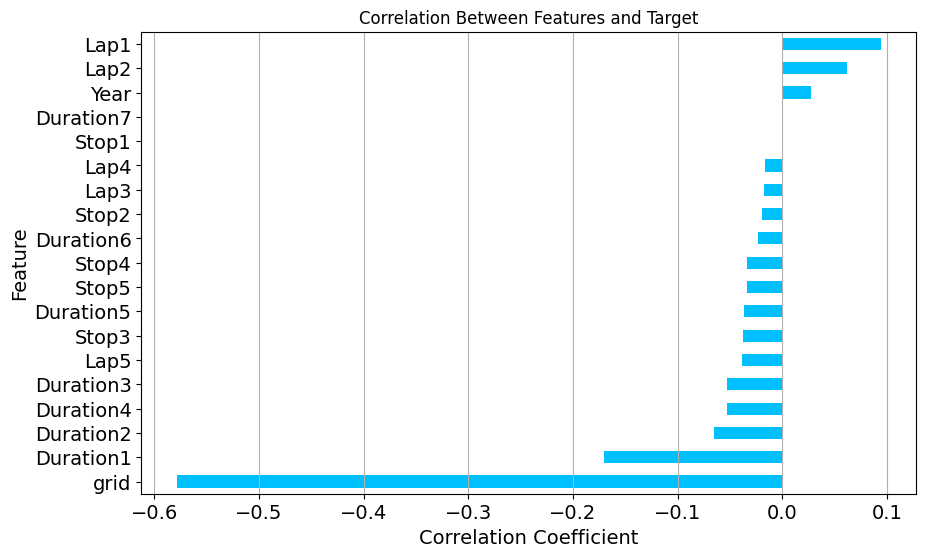

In [9]:
plt.figure(figsize=(10, 6))
correlations = X.corrwith(y)
correlations.sort_values().plot(kind='barh', color='deepskyblue')
plt.title("Correlation Between Features and Target")
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x')
plt.show()

## Recursive Feature Elimination

RFE is a wrapper method that iteratively removes the least important features based on a model's performance.

**Process**:

1. Train a machine learning model.
2. Rank features based on their importance or weights.
3. Recursively eliminate the least significant feature(s) and retrain the model.
4. Stop when the desired number of features is selected.

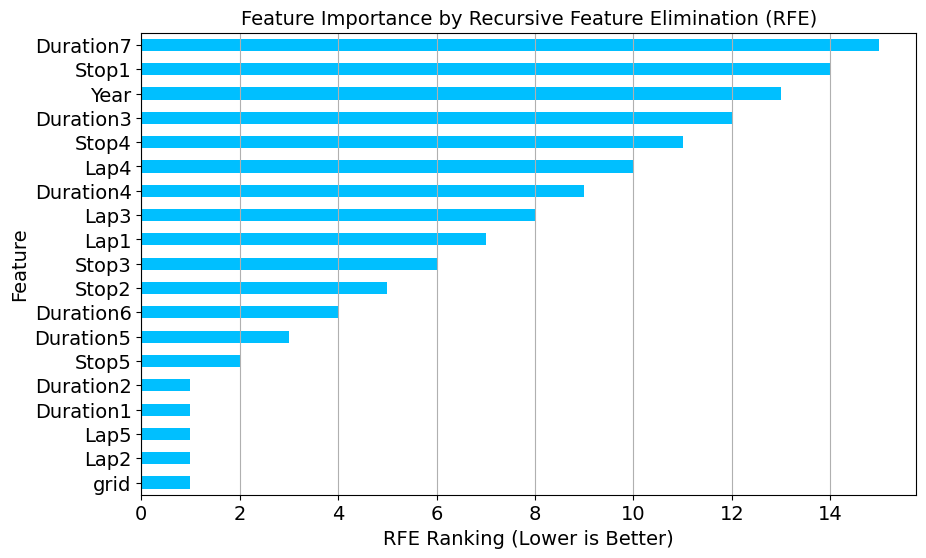

In [10]:
# inititlize logistic regression model
model = LogisticRegression(max_iter=1000, random_state=123)
# initialize RFE with the logistic regression model 
rfe = RFE(model, n_features_to_select=5)
# fit RFE on data
rfe.fit(X, y)
# generate rankings for the features
# 1 = most important 
# higher ranks indicate lower importance
rfe_ranking = pd.Series(rfe.ranking_, index=features).sort_values()

plt.figure(figsize=(10, 6))
rfe_ranking.plot(kind='barh', color='deepskyblue')
plt.title("Feature Importance by Recursive Feature Elimination (RFE)", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("RFE Ranking (Lower is Better)", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x')
plt.show()

## Mutual Information

Mutual information measures the dependency between two variables. It identifies the most informative features by quantifying how much knowing one variable reduces uncertainty about the other

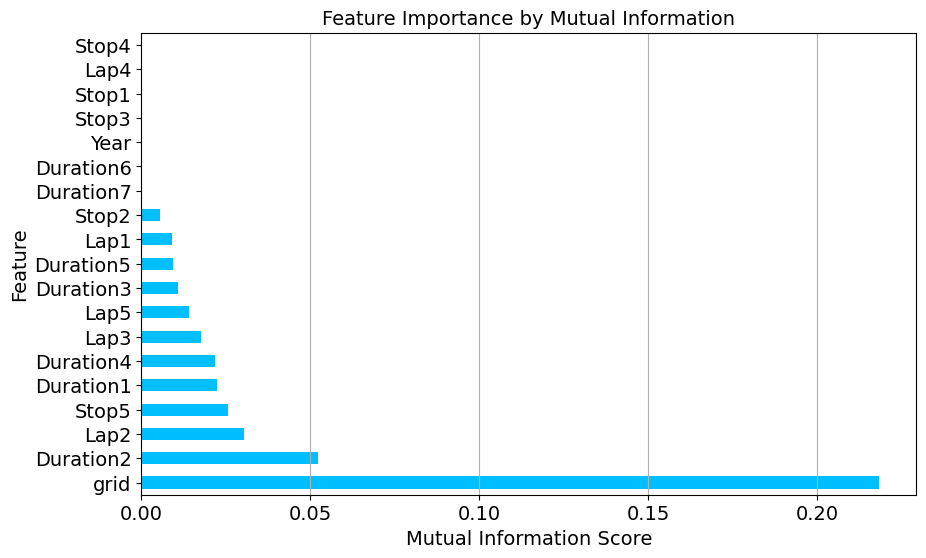

In [11]:
# compute MI between each features and y
mutual_info = mutual_info_classif(X, y, random_state=123)
mutual_info_series = pd.Series(mutual_info, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mutual_info_series.plot(kind='barh', color='deepskyblue')
plt.title("Feature Importance by Mutual Information", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xlabel("Mutual Information Score", fontsize=14)
plt.grid(axis='x')
plt.show()

Selected Features:
`grid`,` Duration1`, `Duration2`, `Lap1`, `Lap2`, `Lap3`,` Stop2`, `Stop3`

These features have been consistenly selected as important by the Feature Selection Algorithms.


# Binary Classification

## Decision Trees
A Decision Tree is a supervised machine learning algorithm used for both classification and regression tasks. It operates by recursively splitting the dataset based on the most informative features, represented as a tree-like structure of decisions. Each node in the tree represents a feature, branches represent decisions or splits, and the leaves represent the final outcome.

**Process**:

-	Decision Trees identify the best feature for splitting the data at each step. Splits are made to maximize homogeneity within the resulting subsets.
    - For classification, splitting is often based on measures like Gini Impurity or Entropy (Information Gain)
    - For regression, the split minimizes the Mean Squared Error (MSE).
-	Recursive Partitioning: The algorithm continues to split the data until a stopping condition is met, such as reaching a maximum depth, minimum samples in a node, or no further gain from splitting.
-	Prediction:
    - In classification, predictions are based on the majority class in the leaf node.
    - In regression, predictions are based on the average value in the leaf node.

**Hyperparameters**:

1.	`max_depth`: Limits the depth of the tree. A smaller depth reduces overfitting but may underfit the data.
2.	`min_samples_split`: The minimum number of samples required to split a node. Increasing this value reduces overfitting by preventing small, irrelevant splits.
3.	`min_samples_leaf`: Specifies the minimum number of samples a leaf node must contain. Larger values result in smoother decision boundaries.
4.	`criterion`: Determines the measure of impurity.
5.	`max_features`: Limits the number of features considered at each split, reducing overfitting and computational cost.
6.	`max_leaf_nodes`: Limits the number of leaf nodes in the tree

**Evaluation Metrics**:

- Accuracy: Measures the percentage of correctly predicted instances.
- Precision: Fraction of true positive predictions out of all positive predictions.
   $$ Precision = \frac{TP}{TP + FP}$$
- Recall (Sensitivity): Fraction of actual positives correctly identified.
$$ Recall = \frac{TP}{TP + FN}$$
- F1-Score: Harmonic mean of precision and recall, useful when dealing with imbalanced classes.
$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$
- Confusion Matrix: Provides a matrix of predicted vs. actual class labels, offering insights into false positives, false negatives, etc.
- ROC-AUC Score: Evaluates the trade-off between true positive rate and false positive rate.

**Challenges**

- Trees tend to overfit when they grow too deep, capturing noise in the data.
- Bias to Greedy Splits: Decision Trees use a greedy approach, which may lead to suboptimal splits.
- Instability: Small changes in the data can result in significant changes in the tree structure



In [21]:
df_transformed = pd.read_csv("../../data/processed-data/pitstop_with_positions.csv")
# create a new categortical variable - 1 if its a points finish
#                                    - 0, otherwise
df_transformed['points_category'] = df_transformed['position'].apply(lambda x: 1 if x <= 10 else 0)


In [22]:
# Selected features
X = df_transformed[['grid', 'Duration1', 'Duration2', 'Lap1', 'Lap2', 'Lap3', 'Stop2', 'Stop3']]
y = df_transformed['points_category']  

# Train-test split
# splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67       114
           1       0.71      0.66      0.68       128

    accuracy                           0.67       242
   macro avg       0.67      0.67      0.67       242
weighted avg       0.68      0.67      0.67       242



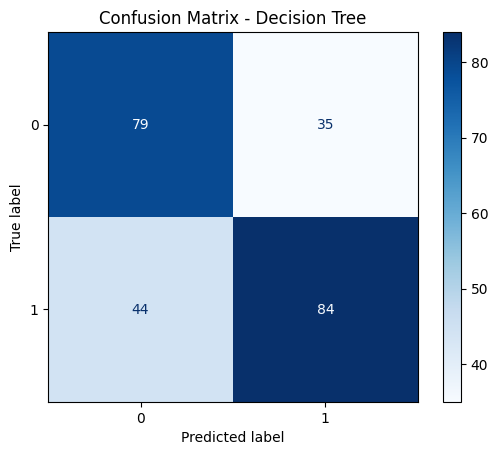

In [23]:
# Initialize the Decision Tree Classifier
# training with default values
dt = DecisionTreeClassifier(random_state=42)

# Fit the model
dt.fit(X_train, y_train)

# Predict on test set
y_pred = dt.predict(X_test)

# Evaluation Metrics
print("Classification Report - Decision Tree:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


- The model performs similarly for both classes, indicated by similar recall, and f-1 scores.
- 67% accuracy indcates that the model can be imporoved further with hyperparameter tuning.
- There is no significant class imbalance.

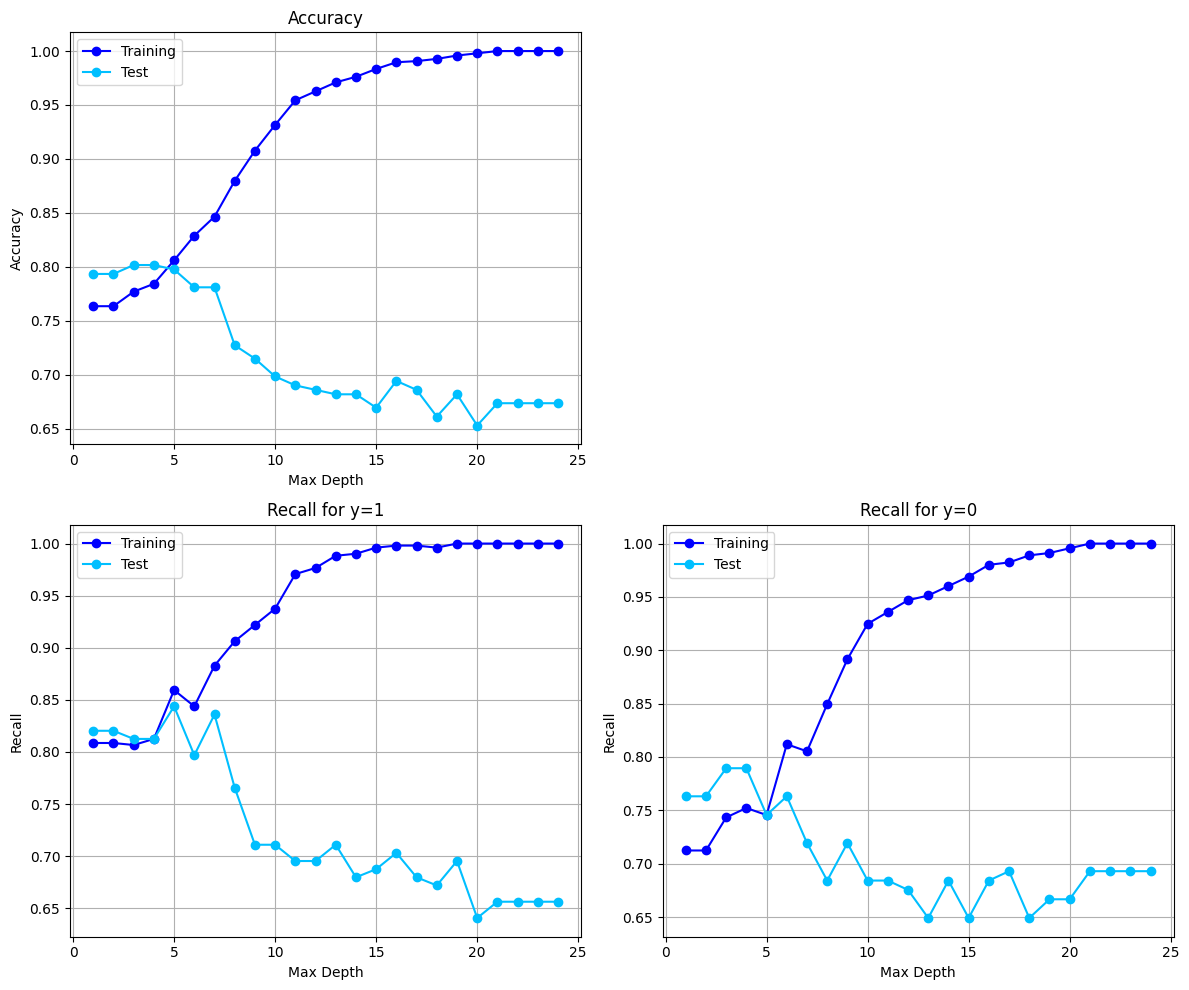

In [26]:
# Hyperparameter Tuning
# Define max_depth range
max_depth_range = range(1, 25)

# Store metrics for each max_depth
train_accuracies_y1 = []  # Accuracy for y=1
test_accuracies_y1 = []
train_recalls_y0 = []     # Recall for y=0
test_recalls_y0 = []

train_accuracies = []     # Overall accuracy
test_accuracies = []
train_recalls = []        # Overall recall for y=1
test_recalls = []

for max_depth in max_depth_range:
    # Initialize Decision Tree Classifier
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    
    # Predictions on training and test data
    y_train_pred = dt.predict(X_train)
    y_test_pred = dt.predict(X_test)
    
    # Calculate overall accuracy
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))
    
    # Calculate recall for y=1
    train_recalls.append(recall_score(y_train, y_train_pred, pos_label=1))
    test_recalls.append(recall_score(y_test, y_test_pred, pos_label=1))
    
    # Accuracy for y=1
    train_accuracies_y1.append(accuracy_score(y_train[y_train == 1], y_train_pred[y_train == 1]))
    test_accuracies_y1.append(accuracy_score(y_test[y_test == 1], y_test_pred[y_test == 1]))
    
    # Recall for y=0
    train_recalls_y0.append(recall_score(y_train, y_train_pred, pos_label=0))
    test_recalls_y0.append(recall_score(y_test, y_test_pred, pos_label=0))

# Plotting all metrics in a (2, 2) grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: Overall Accuracy
axes[0, 0].plot(max_depth_range, train_accuracies, 'o-', label='Training', color='blue')
axes[0, 0].plot(max_depth_range, test_accuracies, 'o-', label='Test', color='deepskyblue')
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_xlabel("Max Depth")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Subplot 2: Recall for y=1
axes[1, 0].plot(max_depth_range, train_recalls, 'o-', label='Training', color='blue')
axes[1, 0].plot(max_depth_range, test_recalls, 'o-', label='Test', color='deepskyblue')
axes[1, 0].set_title("Recall for y=1")
axes[1, 0].set_xlabel("Max Depth")
axes[1, 0].set_ylabel("Recall")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Subplot 3: Recall for y=0
axes[1, 1].plot(max_depth_range, train_recalls_y0, 'o-', label='Training', color='blue')
axes[1, 1].plot(max_depth_range, test_recalls_y0, 'o-', label='Test', color='deepskyblue')
axes[1, 1].set_title("Recall for y=0")
axes[1, 1].set_xlabel("Max Depth")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].legend()
axes[1, 1].grid(True)

fig.delaxes(axes[0, 1])
plt.tight_layout()
plt.show()


As the depth of the tree increases, the training accuracy of the model increases and the test accuracy of the model decreases. This is because the model starts to overfit the training data. To avoid overfitting of the model, we select the optimal number of layers when the test and training accuracy are high. In this case, we select the **max depth to be 5**. Beyond 5, the test accruacy significantly drops.

Best Parameters: {'min_samples_leaf': 2, 'min_samples_split': 5}
Classification Report - Optimized Decision Tree with max_depth=5:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       114
           1       0.79      0.84      0.82       128

    accuracy                           0.80       242
   macro avg       0.80      0.79      0.80       242
weighted avg       0.80      0.80      0.80       242



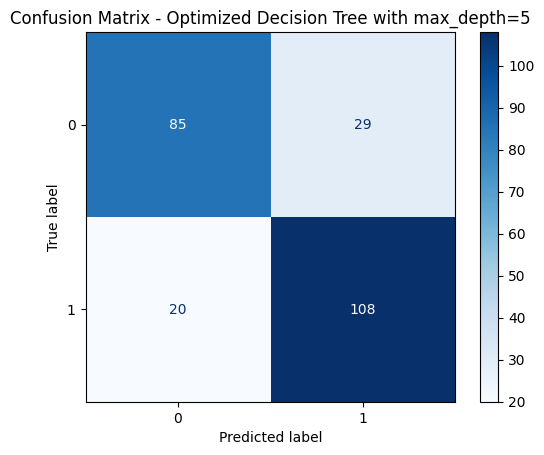

In [19]:
# Hyper parameter tuning
# fix max_depth = 5
# define the parameter grid 
param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Perform Grid Search with max_depth fixed as 5 
grid_search = GridSearchCV(DecisionTreeClassifier(max_depth=5, random_state=123), 
                           param_grid, cv=5, scoring='accuracy')
# fit the model to the training data
grid_search.fit(X_train, y_train)

# results
print("Best Parameters:", grid_search.best_params_)

# evaluate the best model
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)

# evaluation metrics
print("Classification Report - Optimized Decision Tree with max_depth=5:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Optimized Decision Tree with max_depth=5")
plt.show()


- After hyperparameter tuning, we observe a significant increase in accuracy.
- The precision for the turned model is also more balanced than the original model.

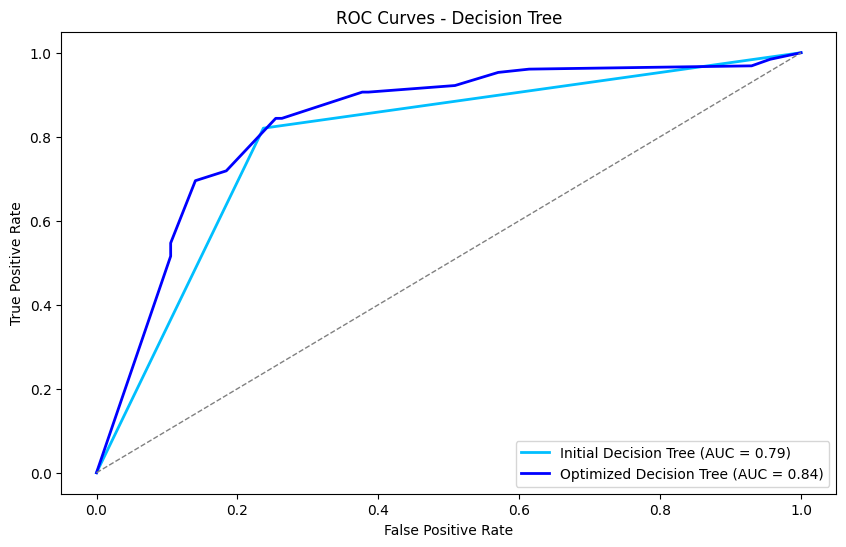

In [20]:
# ROC Curve for the Initial Decision Tree
y_proba_initial = dt.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr_initial, tpr_initial, _ = roc_curve(y_test, y_proba_initial)
roc_auc_initial = auc(fpr_initial, tpr_initial)

# ROC Curve for the Optimized Decision Tree
y_proba_optimized = best_dt.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_proba_optimized)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot both ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_initial, tpr_initial, label=f'Initial Decision Tree (AUC = {roc_auc_initial:.2f})', color='deepskyblue', lw=2)
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized Decision Tree (AUC = {roc_auc_optimized:.2f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Decision Tree')
plt.legend(loc="lower right")
plt.show()


-	**The Receiver Operating Characteristic (ROC)** curve is used to evaluate the trade-off between True Positive Rate (TPR) (sensitivity/recall) and False Positive Rate (FPR) across different threshold values.
-	**Area Under The Curve (AUC)** represents the measure of separability. Higher the AUC, the better is the model at predicting the classes. 
- The optimized Decision Tree outperforms the initial model, as evidenced by the higher AUC (0.84 vs. 0.79). Hyperparameter tuning has led to improvements in the model’s performance. 


## Random Forest
Random Forests combine the strengths of multiple decision trees to deliver a robust, versatile, and high-performing model for classification and regression tasks.

**Process**:

-  Random Forest builds multiple decision trees using bootstrap aggregation, where each tree is trained on a bootstrapped subset of the data.
- At each node, a random subset of features is considered for splitting, introducing diversity among the trees and reducing overfitting.
- Each tree is grown independently to its maximum depth or based on stopping criteria like max_depth or min_samples_split.
- For classification tasks, the final prediction is determined through a majority vote from all trees. For regression tasks, the final output is obtained by averaging the predictions of all trees.
- By combining outputs from multiple decision trees, Random Forest reduces variance, improves generalization, and enhances model robustness.

In [27]:
df_transformed = pd.read_csv("../../data/processed-data/pitstop_with_positions.csv")
df_transformed['points_category'] = df_transformed['position'].apply(lambda x: 1 if x <= 10 else 0)
X = df_transformed[['grid', 'Duration1', 'Duration2', 'Lap1', 'Lap2', 'Lap3', 'Stop2', 'Stop3']]
y = df_transformed['points_category']  

# Train-test split
# splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       114
           1       0.80      0.82      0.81       128

    accuracy                           0.79       242
   macro avg       0.79      0.79      0.79       242
weighted avg       0.79      0.79      0.79       242



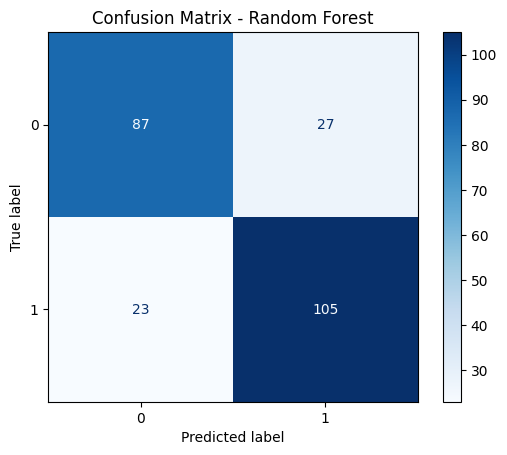

Accuracy: 0.7933884297520661


In [28]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=123)

# Train the model
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Accuracy Score
print("Accuracy:", accuracy_score(y_test, y_pred))


The Random Forest Classifier, using its default hyperparameters, achieved an accuracy of approximately 0.80. Comparable to a Decision Tree after hyperparameter tuning, this highlights the superior performance and robustness of Random Forests, especially when handling large datasets, as they effectively reduce overfitting compared to a single decision tree.

In [29]:
# hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10]
}

# grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=123),
                           param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# results
print("Best Parameters:", grid_search.best_params_)

# evaluate with best parameters
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Classification Report
print("Classification Report - Optimized Random Forest:")
print(classification_report(y_test, y_pred_best))


Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report - Optimized Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       114
           1       0.81      0.83      0.82       128

    accuracy                           0.81       242
   macro avg       0.81      0.80      0.80       242
weighted avg       0.81      0.81      0.81       242



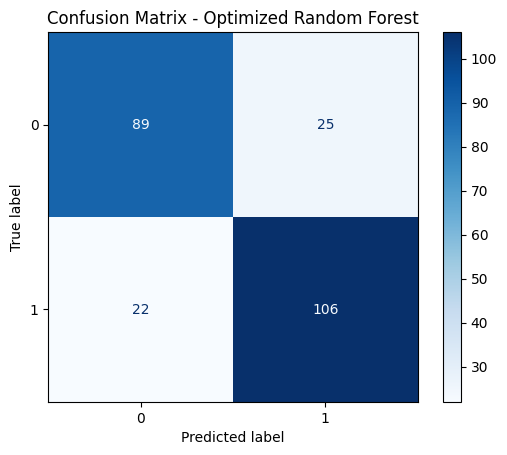

In [30]:
# Confusion Matrix for Optimized Random Forest
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Optimized Random Forest")
plt.show()

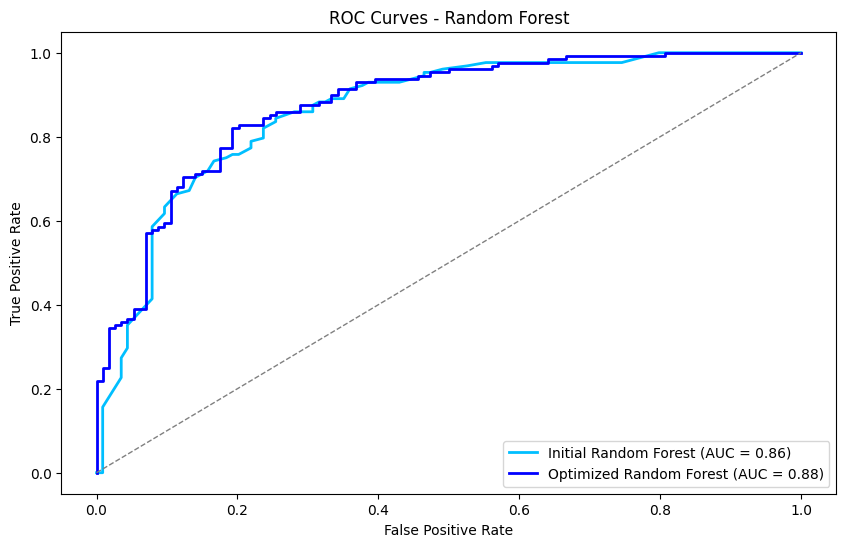

In [31]:
# ROC Curve for the Initial Random Forest
y_proba_initial = rf.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr_initial, tpr_initial, _ = roc_curve(y_test, y_proba_initial)
roc_auc_initial = auc(fpr_initial, tpr_initial)

# ROC Curve for the Optimized Random Forest
y_proba_optimized = best_rf.predict_proba(X_test)[:, 1]  # Probability for the positive class
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_proba_optimized)
roc_auc_optimized = auc(fpr_optimized, tpr_optimized)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_initial, tpr_initial, label=f'Initial Random Forest (AUC = {roc_auc_initial:.2f})', color='deepskyblue', lw=2)
plt.plot(fpr_optimized, tpr_optimized, label=f'Optimized Random Forest (AUC = {roc_auc_optimized:.2f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Random Forest')
plt.legend(loc="lower right")
plt.show()


- The Random Forest Classifier has outperformed the Decision Tree in terms of accuracy, demonstrating a higher capability to classify race outcomes more effectively using the pit stop data.
- This also suggests that race outcomes are significantly influenced by pit stop strategies, highlighting an important insight that can help predict potential race winners.

# Multiclass Classification

## Random Forest Classifier

In [36]:
# Create a new column with binned classes based on 'position'
# multiclass categorical variable
def position_to_class(position):
    if 1 <= position <= 5:
        return 1
    elif 6 <= position <= 10:
        return 2
    elif 11 <= position <= 15:
        return 3
    elif 16 <= position <= 20:
        return 4
    else:
        return None  

df_transformed['position_class'] = df_transformed['position'].apply(position_to_class)

df_transformed = df_transformed.dropna(subset=['position_class'])

# Define features and target
X = df_transformed[['grid', 'Duration1', 'Duration2', 'Lap1', 'Lap2', 'Lap3', 'Stop2', 'Stop3']]
y = df_transformed['position_class']


In [37]:
# Train-test split
# splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)


Classification Report - Multi-class Random Forest:
              precision    recall  f1-score   support

           1       0.65      0.80      0.72        65
           2       0.39      0.41      0.40        63
           3       0.43      0.46      0.44        61
           4       0.57      0.28      0.38        46

    accuracy                           0.51       235
   macro avg       0.51      0.49      0.48       235
weighted avg       0.51      0.51      0.49       235



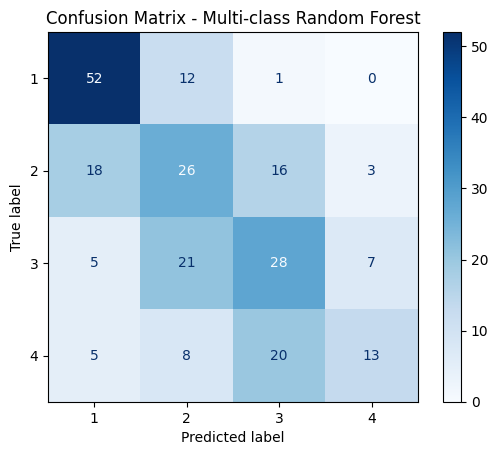

In [38]:
# Initialize Random Forest Classifier
rf_multi = RandomForestClassifier(random_state=123)

# Train the model
rf_multi.fit(X_train, y_train)

# Predict
y_pred_multi = rf_multi.predict(X_test)

# Evaluation Metrics
print("Classification Report - Multi-class Random Forest:")
print(classification_report(y_test, y_pred_multi))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_multi, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Multi-class Random Forest")
plt.show()


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Classification Report - Optimized Multi-class Random Forest:
              precision    recall  f1-score   support

           1       0.66      0.75      0.71        65
           2       0.38      0.40      0.39        63
           3       0.44      0.51      0.47        61
           4       0.58      0.30      0.40        46

    accuracy                           0.51       235
   macro avg       0.52      0.49      0.49       235
weighted avg       0.51      0.51      0.50       235



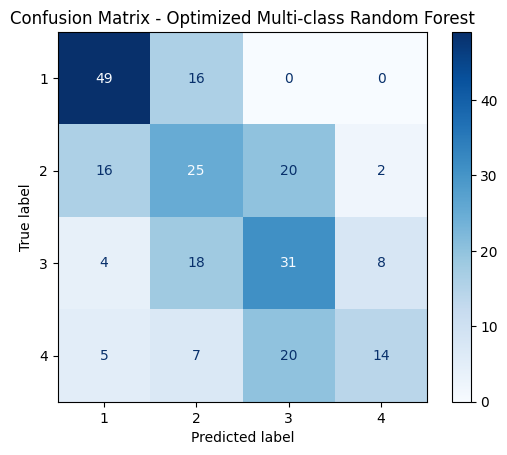

In [39]:
# Hyperparameter tuning
param_grid_multi = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# perform Grid Search
grid_search_multi = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                 param_grid=param_grid_multi, cv=5, scoring='accuracy')
grid_search_multi.fit(X_train, y_train)

# results
print("Best Parameters:", grid_search_multi.best_params_)

# evaluate with best parameters
best_rf_multi = grid_search_multi.best_estimator_
y_pred_best_multi = best_rf_multi.predict(X_test)

# classification report
print("Classification Report - Optimized Multi-class Random Forest:")
print(classification_report(y_test, y_pred_best_multi))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_rf_multi, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Optimized Multi-class Random Forest")
plt.show()


## K-Nearest Neighbors (KNN) 
KNN is a non-parametric and instance-based learning algorithm, meaning it makes no assumptions about the underlying data distribution and makes predictions based on the similarity of the input data to its neighbors. 

**Process**:

-	The algorithm calculates the distance between the input (test) data point and all training data points.
-	Based on the distance metric, KNN identifies the k-nearest neighbors to the test data point.
- Prediction:
  - Classification: The algorithm assigns the class label that is the majority among the k-nearest neighbors (majority voting).
  - Regression: The algorithm averages the values of the k-nearest neighbors to predict the outcome.
  - 
**Hyperparameters**: K – number of neighbors. 


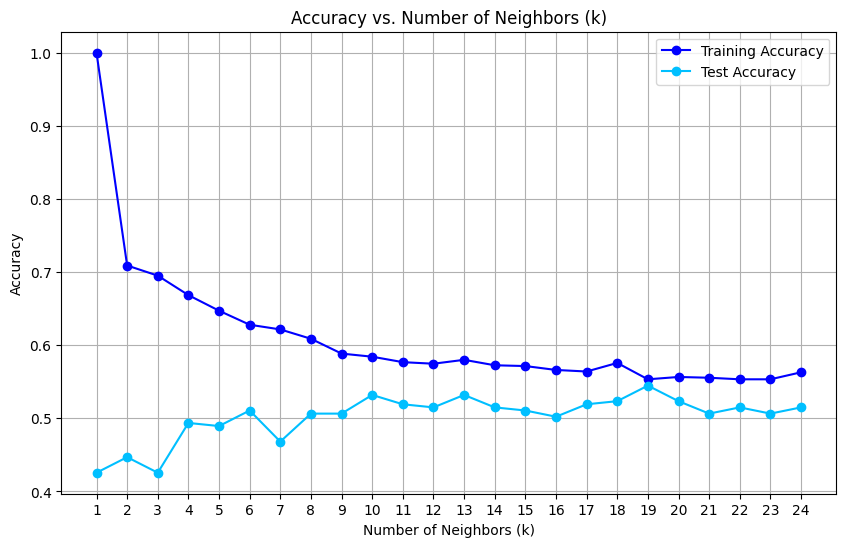

In [46]:
# Range of k values to test
k_values = range(1, 25)

# Lists to store training and test accuracy
train_accuracies = []
test_accuracies = []

for k in k_values:
    # Initialize KNN with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Train the model
    knn.fit(X_train, y_train)
    
    # Predict on training and test data
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    # Calculate accuracy for training and test data
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))

# Plot accuracy vs. k value
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label="Training Accuracy", marker='o', color='blue')
plt.plot(k_values, test_accuracies, label="Test Accuracy", marker='o', color='deepskyblue')
plt.xticks(k_values)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Neighbors (k)")
plt.legend()
plt.grid(True)
plt.show()


Optimal number for k is 19. Beyond 19, the test accuracy starts to drop.

Classification Report - KNN (k=19):
              precision    recall  f1-score   support

           1       0.68      0.80      0.74        65
           2       0.41      0.52      0.46        63
           3       0.44      0.39      0.42        61
           4       0.40      0.22      0.28        46

    accuracy                           0.51       235
   macro avg       0.49      0.48      0.47       235
weighted avg       0.49      0.51      0.49       235



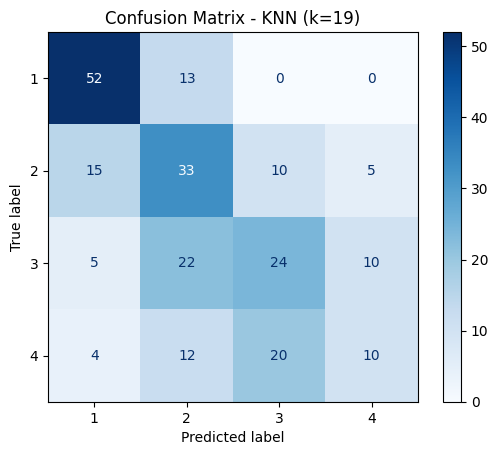

In [40]:
# Initialize KNN with k=19
knn = KNeighborsClassifier(n_neighbors=19)

# Train the model
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate Performance
print("Classification Report - KNN (k=19):")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - KNN (k=19)")
plt.show()

Across models, the first class is consistently classified with the highest accuracy. This indicates that as the granularity of race results increases, classifying exact outcomes based solely on pit stop data becomes more challenging. While it is relatively easier to determine whether a driver will score points or not, accurately predicting the precise finishing position proves to be much more difficult.

# Regression
**Regression** is a class of supervised learning algorithms used to predict continuous target variables by modelling the relationship between the input variables and the target variable. 

**Algorithms used in this project**

1.	Linear Regression: It is one of the most fundamental and widely used regression algorithms. It models the relationships between the dependent variables and the independent variables using a straight line. 
2.	Support Vector Regression (SVR): SVR is an extension of support vector machines for regression tasks. It tries to find a hyperplane that fits the data within a specified margin of tolerance.
3.	Polynomial Regression: Polynomial regression extends linear regression by including polynomial terms (e.g., x2,x3x^2, x^3x2,x3) to capture non-linear relationships. 
4.	Random Forest Regressor: Random forest is an ensemble learning method that aggregates predictions from multiple decision trees to improve accuracy and robustness. 

**Reasons for choosing these algorithms**

- Linear Regression: Provided a baseline model to understand the data's linear trends and evaluate other methods against.
- SVR: Captured non-linear relationships between features and outcomes, offering insights into more complex patterns.
- Polynomial Regression: Enhanced the ability to model curvature and non-linear interactions while maintaining interpretability.
- Random Forest Regressor: Leveraged its robustness and flexibility to handle complex interactions between features, offering strong predictive performance.

**Regularization**

To prevent overfitting, regularization techniques are applied. 
 
-	Ridge Regression: This technique adds an L2 penalty (squared magnitude of coefficients) to the loss function. It shrinks coefficients, effectively preventing overfitting by reducing the model's complexity while retaining all features.
-	Lasso Regression: This method incorporates an L1 penalty (absolute magnitude of coefficients), which not only prevents overfitting but also performs feature selection by forcing some coefficients to become exactly zero. This helps in identifying the most relevant features for the prediction task.

**Evaluation Metrics**:

-	Mean Absolute Error (MAE): Measures the average absolute difference between predicted and actual values, offering a straightforward interpretation of prediction errors.
-	Mean Squared Error (MSE): Computes the average of squared differences between predictions and actual values, penalizing larger errors more heavily than MAE.
-	Root Mean Squared Error (RMSE): The square root of MSE, providing error estimates in the same units as the target variable for easier interpretability.
-	R-squared (R²): Represents the proportion of variance in the target variable explained by the model, with higher values indicating better performance.
-	Adjusted R-squared: Enhances R² by accounting for the number of predictors, discouraging the inclusion of irrelevant features.
-	Mean Absolute Percentage Error (MAPE): Expresses prediction errors as a percentage of actual values, making it useful for comparing across datasets with varying scales.





In [52]:
data = pd.read_csv("../../data/processed-data/pitstop_long.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head()

,Year,Round,RaceName,DriverID,Lap,Stop,Time,Duration
0,0.0,0.0,Australian Grand Prix,alguersuari,0.000000,0.0,0.0,0.451650
1,0.0,0.0,Australian Grand Prix,michael_schumacher,0.000000,0.0,0.0,0.420133
2,0.0,0.0,Australian Grand Prix,webber,0.129870,0.0,0.0,0.393351
3,0.0,0.0,Australian Grand Prix,alonso,0.142857,0.0,0.0,0.390412
4,0.0,0.0,Australian Grand Prix,massa,0.155844,0.0,0.0,0.400336


In [53]:
# Dropping non-numeric columns (RaceName and DriverID) for regression
data = data.drop(columns=["RaceName", "DriverID"])

# defining feature matri 
X = data.drop(columns=["Duration"])  
# defining target variable
y = data["Duration"]  

# splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# 1. Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)
# evaluation metrics for linear regression
print("Linear Regression Metrics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_lr):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lr):.4f}")
print(f"R-squared: {r2_score(y_test, y_pred_lr):.4f}")

# 2. Support Vector Regression (SVR)
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
# evaluation metrics
print("\nSupport Vector Regression Metrics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_svr):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_svr):.4f}")
print(f"R-squared: {r2_score(y_test, y_pred_svr):.4f}")

# 3. Polynomial Regression
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)
# evaluation metrics
print("\nPolynomial Regression Metrics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_poly):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_poly):.4f}")
print(f"R-squared: {r2_score(y_test, y_pred_poly):.4f}")

# 4. Random Forest Regressor
random_forest = RandomForestRegressor(random_state=123)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
# evaluation metrics
print("\nRandom Forest Regressor Metrics:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_rf):.4f}")
print(f"R-squared: {r2_score(y_test, y_pred_rf):.4f}")


Linear Regression Metrics:
Mean Absolute Error: 0.0654
Mean Squared Error: 0.0118
R-squared: 0.0268

Support Vector Regression Metrics:
Mean Absolute Error: 0.0683
Mean Squared Error: 0.0104
R-squared: 0.1385

Polynomial Regression Metrics:
Mean Absolute Error: 0.0654
Mean Squared Error: 0.0116
R-squared: 0.0444

Random Forest Regressor Metrics:
Mean Absolute Error: 0.0341
Mean Squared Error: 0.0043
R-squared: 0.6408


- Random Forest Regressor significantly outperforms other models in terms of MAE, MSE, and R-Squared metrics. 
- Linear and Polynomial Regression models seem to struggle due to inherent complexity and non-linearity in the data.
- SVR performs better than Linear Regression but still underperformed compared to Random Forest Regressor.
- The results show that non-linear models are better suited for out data. 

We will tune the Random Forest Regressor to improve its accuracy further.

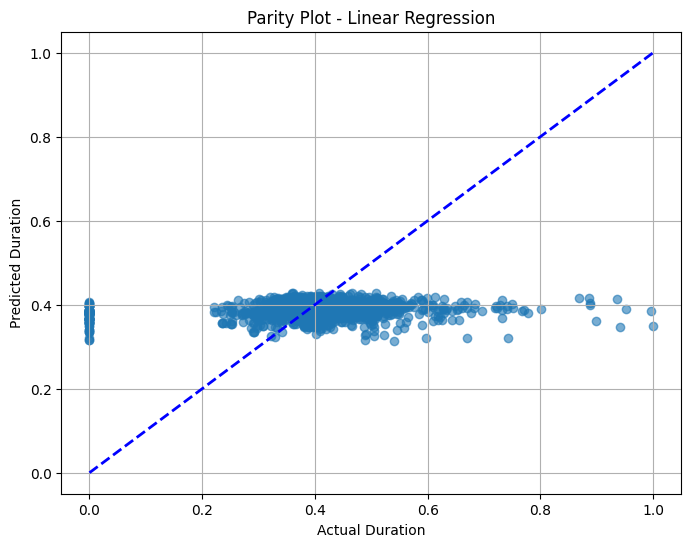

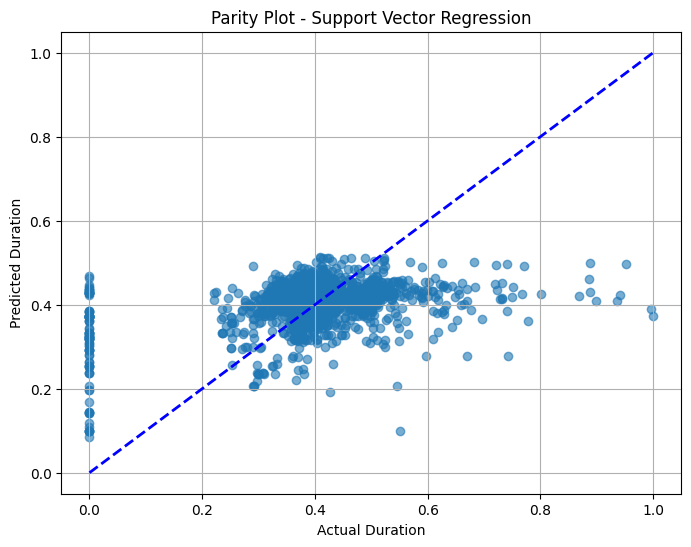

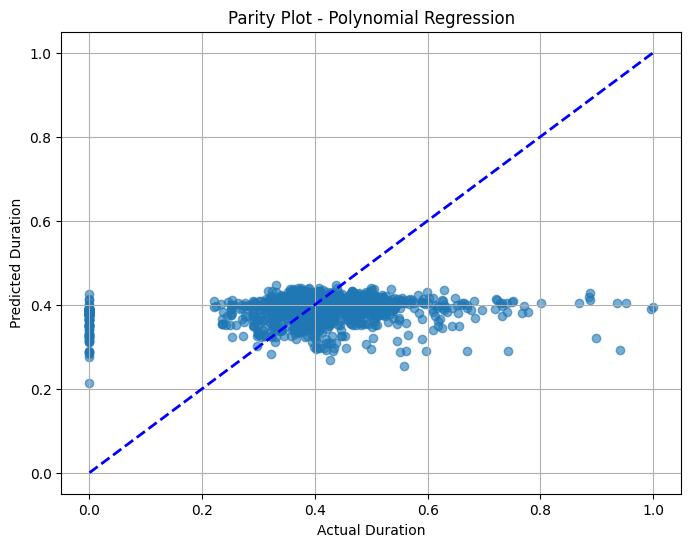

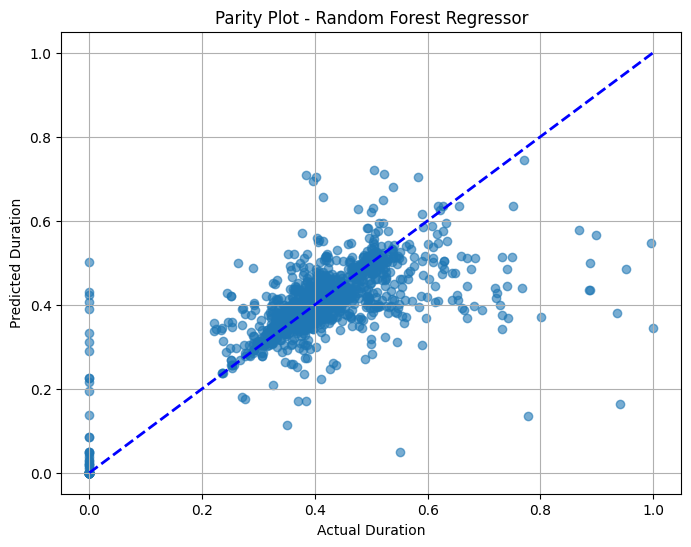

In [111]:
# Plotting function for parity plots
def plot_parity(y_actual, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_pred, alpha=0.6)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'b--', lw=2)
    plt.xlabel("Actual Duration")
    plt.ylabel("Predicted Duration")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Visualize parity plots for each algorithm
# 1. Linear Regression
plot_parity(y_test, y_pred_lr, "Parity Plot - Linear Regression")

# 2. Support Vector Regression (SVR)
plot_parity(y_test, y_pred_svr, "Parity Plot - Support Vector Regression")

# 3. Polynomial Regression
plot_parity(y_test, y_pred_poly, "Parity Plot - Polynomial Regression")

# 4. Random Forest Regressor
plot_parity(y_test, y_pred_rf, "Parity Plot - Random Forest Regressor")


In [54]:
# optimizing random forest regressor
# Parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# grid search 
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=123),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

In [ ]:

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf = grid_search.best_estimator_

# Predict on test set
y_pred_rf = best_rf.predict(X_test)



In [56]:
# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("\nOptimized Random Forest Regressor Metrics:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Optimized Random Forest Regressor Metrics:
Mean Absolute Error: 0.0343
Mean Squared Error: 0.0043
R-squared: 0.6439


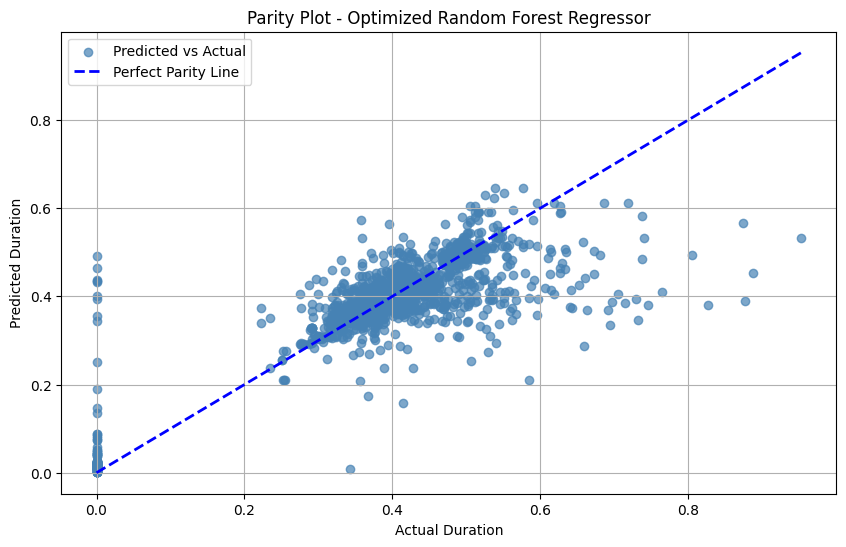

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, label="Predicted vs Actual", color="steelblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2, label="Perfect Parity Line")  # Red dashed line for perfect prediction
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Parity Plot - Optimized Random Forest Regressor")
plt.legend()
plt.grid(True)
plt.show()


The Parity Plot compares the predicted values of "Duration" (on the y-axis) with the actual values (on the x-axis) for the optimized Random Forest Regressor. The blue dashed line represents the perfect parity line, where predicted values are equal to actual values.

- Most of the points are concentrated near the parity line, indicating that the Random Forest model performs well in predicting the "Duration", this suggests a good agreement between predicted and actual values.
- There are some outliers where the predicted durations deviate significantly from the actual values, especially for very low or very high durations.
- While the model performs well overall, further refinements, such as handling outliers or incorporating additional features, could improve accuracy, especially for extreme values.